<a href="https://colab.research.google.com/github/dyjdlopez/cycu-power-system-optimization/blob/main/01%20-%20economic%20dispatch/01-%20ed01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Economic Dispatch Solutions in Python
$\text{by D.J.D. Lopez (迪倫)}$

This Colab Notebook shows an example in solving economic dispatch (ED) with no constraints and no transmission loss using Python. The current implementation uses `sympy` for symbolic algebraic expression to demonstrate a simple algebraic solution. A more sophisticated optimization solution will be made in the succeeding notebooks using numerical optimization.

In [ ]:
import numpy as np
from scipy.misc import derivative as d
from sympy import *
from IPython.display import display, Math
import pandas as pd

import matplotlib.pyplot as plt

## 1.1 ED neglecting generator limits and line losses

An area of an interconnected power systeamw has two fossi-fuel units operating on economic dispatch. The variable costs of these units are given by:
$$C_1 = 10P_1 + 0.008P^2_1\\ C_2 =8P_2 + 0.009P^2_2$$
where $P_1$ and $P_2$ are in MW and $C_1$ and $C_2$ are in $\frac{$}{h}$. Determine the **power ouput of each unit**, the **incremental operating cost**, and the **total operating cost $C_T$ that minimizes $C_T$** as the total demand $P_t$ varies from 500 to 1500 MW.

In [ ]:
Pt = np.arange(500, 1600, 100)

Initiate the variables $P_1$, $P_2$, $P_T$, and $L$ as the power generated by the first and second generatior, the total power generated, and the incremental operating cost.

The costs $C_1$ and $C_2$ are given from the problem definition above. They are then encoded using `sympy` below.

In [ ]:
P1, P2, PT, L = symbols("P1 P2 PT L")

C1 = 10*P1+8e-3*P1**2
C2 = 8*P2+9e-3*P2**2

display(Math(rf'$C_1 = {latex(C1)}$'))
display(Math(rf'$C_2 = {latex(C2)}$'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

To solve the individual **unit incremental operating costs** $\frac{dC_1}{dP_1}$ and $\frac{dC_2}{dP_2}$ would be manuall solved to be:

$$\frac{dC_1}{dP_1} = 10 + 0.0016P_1\\ \frac{dC_2}{dP_2} = 8 + 0.0018P_2$$

In this solution, they are automatically solved using `sympy`'s `diff()` function to get the derivatives of each operating cost with their power generated.

In [ ]:
dC1 = diff(C1)
dC2 = diff(C2)

display(Math(rf'$\frac{{dC_1}}{{dP_1}} = {latex(dC1)}$'))
display(Math(rf'$\frac{{dC_2}}{{dP_2}} = {latex(dC2)}$'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

We can then solve for the optimal values of $P_1$ and $P_2$ by equating $\frac{dC_1}{dP_1}$ and $\frac{dC_2}{dP_2}$ using the idea that $$\frac{dC_1}{dP_1} -\frac{dC_2}{dP_2}=0$$

In [ ]:
Eq = dC1 - dC2
P1_s = solve(Eq.subs(P2, PT-P1), P1)[0]
display(Math(rf'P1 = {latex(P1_s)}'))

<IPython.core.display.Math object>

In [ ]:
P2_s = (PT - P1).subs(P1, P1_s)
display(Math(rf'P2 = {latex(P2_s)}'))

<IPython.core.display.Math object>

The incremental cost equation can then be solved by working algebraic substitution between the derived $P_1$ to the original $P_1$ equation we should get:
$$9.0589 + 0.0084704P_T$$

In [ ]:
L = dC1.subs(P1, P1_s)
display(Math(rf'λ = {latex(L)}'))

<IPython.core.display.Math object>

The symbolic function is then converted to a python function using the `lambdify()` function from `sympy`

In [ ]:
inc_cost = lambdify(PT, L, "numpy")

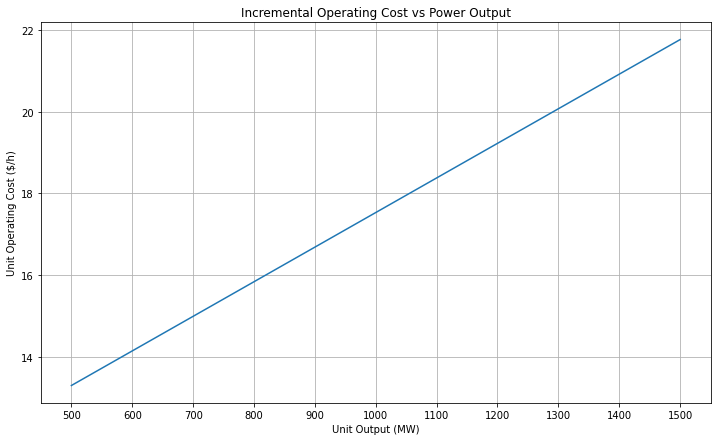

In [ ]:
plt.figure(figsize=(12,7))

plt.title('Incremental Operating Cost vs Power Output')

plt.plot(Pt, inc_cost(Pt))

plt.xticks(Pt)
plt.xlabel('Unit Output (MW)')
plt.ylabel('Unit Operating Cost ($/h)')

plt.grid()
plt.show()

We also lambdify the symbolic functions derived from above into lambda functions.

In [ ]:
CT = C1 + C2

c_t = lambdify((P1, P2), CT)
p1 = lambdify(PT, P1_s)
p2 = lambdify(PT, P2_s)

c1 = lambdify(P1, C1)
c2 = lambdify(P2, C2)

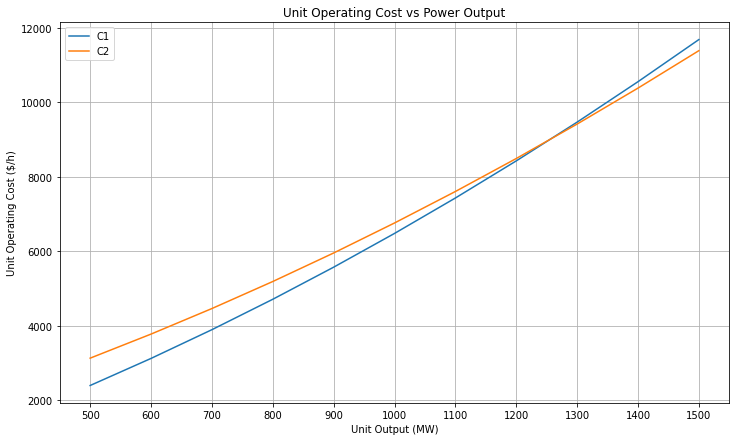

In [ ]:
plt.figure(figsize=(12,7))

plt.title('Unit Operating Cost vs Power Output')

plt.plot(Pt, c1(p1(Pt)), label='C1')
plt.plot(Pt, c2(p2(Pt)), label='C2')

plt.xticks(Pt)
plt.xlabel('Unit Output (MW)')
plt.ylabel('Unit Operating Cost ($/h)')

plt.grid()
plt.legend()
plt.show()

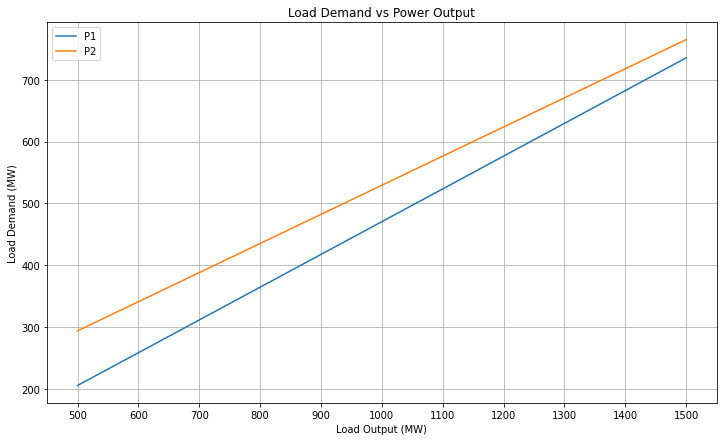

In [ ]:
plt.figure(figsize=(12,7))

plt.title('Load Demand vs Power Output')

plt.plot(Pt, p1(Pt), label='P1')
plt.plot(Pt, p2(Pt), label='P2')

plt.xticks(Pt)
plt.xlabel('Load Output (MW)')
plt.ylabel('Load Demand (MW)')

plt.grid()
plt.legend()
plt.show()

In [ ]:
dispatch_soln = {
    'PT (MW)': Pt,
    'P1 (MW)': np.round(p1(Pt)),
    'P2 (MW)': np.round(p2(Pt)),
    'dC1/dP1 ($/MWh)': np.round(inc_cost(Pt),2),
    'CT ($/h)': np.round(c_t(p1(Pt), p2(Pt))) 
}
dispatch_df = pd.DataFrame(dispatch_soln)
dispatch_df

,PT (MW),P1 (MW),P2 (MW),dC1/dP1 ($/MWh),CT ($/h)
0,500,206.0,294.0,13.29,5529.0
1,600,259.0,341.0,14.14,6901.0
2,700,312.0,388.0,14.99,8358.0
3,800,365.0,435.0,15.84,9899.0
4,900,418.0,482.0,16.68,11525.0
5,1000,471.0,529.0,17.53,13235.0
6,1100,524.0,576.0,18.38,15031.0
7,1200,576.0,624.0,19.22,16911.0
8,1300,629.0,671.0,20.07,18875.0
9,1400,682.0,718.0,20.92,20925.0


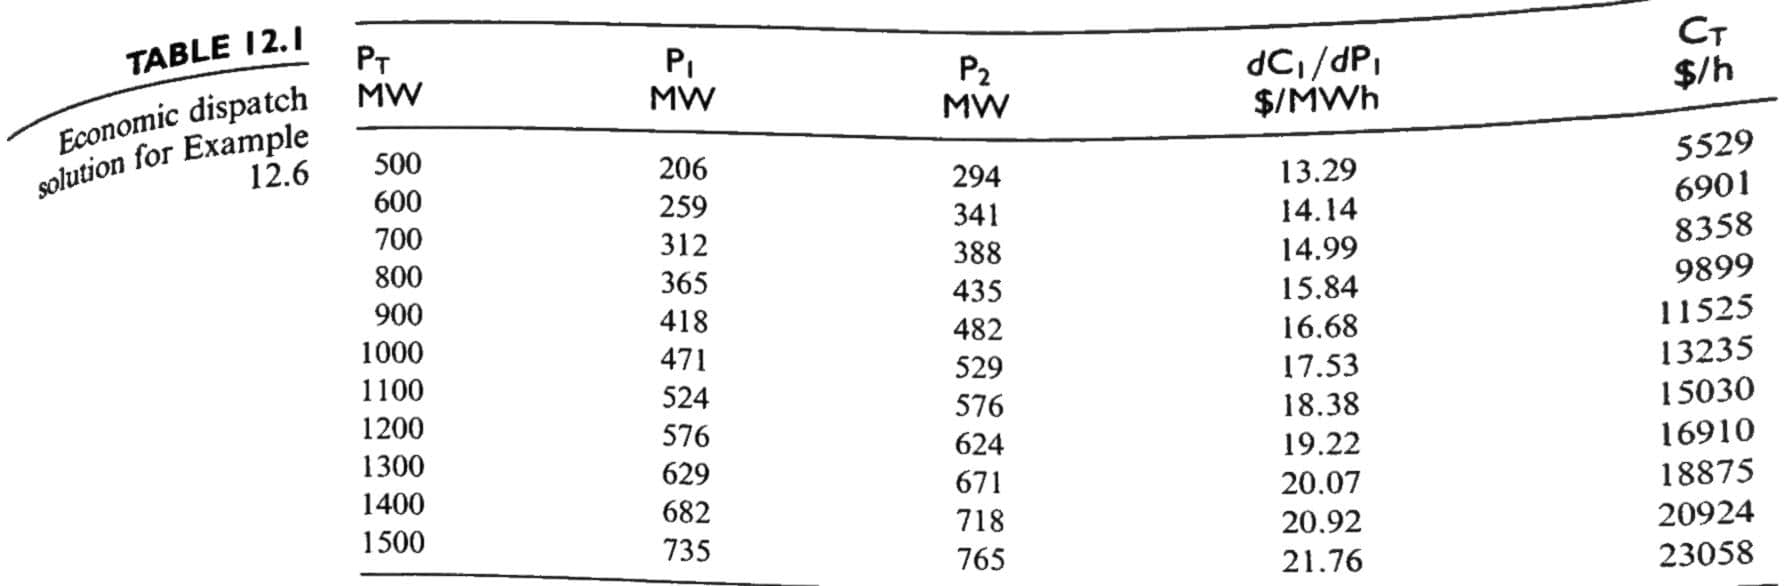